In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib as mpl
mpl.style.use('seaborn-notebook')

In [2]:
df_tone = pd.read_csv("data/tonedata.csv", sep=" ")
df_tone

,stretchratio,tuned
0,1.35,1.461
1,1.40,1.407
2,1.45,1.452
3,1.50,1.300
4,1.55,1.351
...,...,...
145,2.75,2.066
146,2.80,2.426
147,2.85,2.117
148,2.90,2.097


In [3]:
X = df_tone.stretchratio.values
Xs = X.reshape(-1,1)
Y = df_tone.tuned.values

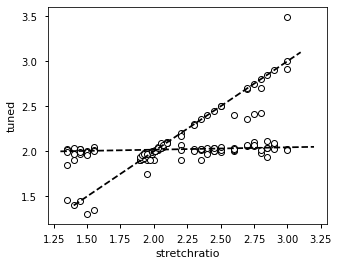

In [16]:
plt.figure(figsize=(5.0, 4.0))
plt.scatter(X, Y, s=36, c='w', edgecolors='k', linewidths=1.)
# plt.title('Tone data')
# plt.minorticks_on()
# plt.grid(1)
plt.plot([1.4, 3.1], [1.4, 3.1], linestyle='--', color='k')
plt.plot([1.3, 3.2], [2.0, 2.05], linestyle='--', color='k')
plt.xlabel('stretchratio')
plt.ylabel('tuned')
plt.savefig('fig/kmean_regression_tonedata.eps')
plt.show()

In [8]:
import mlgrad
import mlgrad.model as ml_model
import mlgrad.risk as ml_risk
import mlgrad.loss as ml_loss
import mlgrad.weights as ml_weights
import mlgrad.func as ml_func
import mlgrad.af as ml_af

In [149]:
# minloss_min = ml_loss.SoftMinLoss(ml_loss.SquareErrorLoss(), 2, a=15)
minloss_sq = ml_loss.SoftMinLoss(ml_loss.SquareErrorLoss(), 2, a=15)
minloss_abs = ml_loss.SoftMinLoss(ml_loss.ErrorLoss(ml_func.SoftAbs(0.001)), 2, a=15)

In [170]:
def make_models():
    layer = ml_model.GeneralModelLayer(1)
    linmod1 = ml_model.LinearModel(1)
    linmod2 = ml_model.LinearModel(1)
    layer.append(linmod1)
    layer.append(linmod2)
    nn = ml_model.FFNetworkModel()
    nn.add(layer)

    nn.allocate()
    nn.init_param()
    
    return nn, linmod1, linmod2

def solve(minloss):
    nn, linmod1, linmod2 = make_models()
    risk = ml_risk.ER21(Xs, Y, nn, minloss)
    alg = mlgrad.erm_fg(risk, n_restart=5, h=0.005, tol=1.0e-9, n_iter=2000)
    return alg, nn, linmod1, linmod2 

def rob_solve(minloss, alpha=0.95):
    nn, linmod1, linmod2 = make_models()
    risk = ml_risk.ER21(Xs, Y, nn, minloss)
    agg_func = ml_af.averaging_function("WM", alpha=alpha, rhofunc=ml_func.Sqrt(0.001))
    weights = ml_weights.MWeights(agg_func, risk)
    _fg = mlgrad.fg(risk, h=0.005, tol=1.0e-9, n_iter=2000)
    alg = mlgrad.erm_irgd(_fg, weights, tol=1.0e-7, n_restart=1)
    return alg, nn, linmod1, linmod2
    

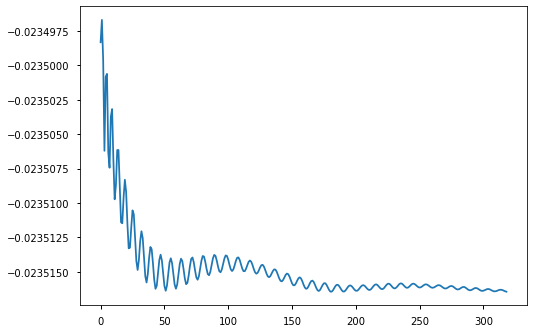

In [171]:
alg_sq, nn, linmod1, linmod2 = solve(minloss_sq)

plt.plot(alg_sq.lvals)
plt.show()

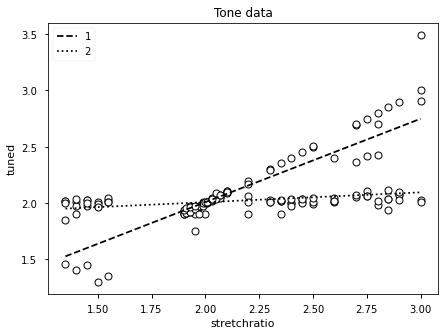

In [172]:
plt.figure(figsize=(7,5))
plt.scatter(X, Y, s=49, c='w', edgecolors='k', linewidth=1.0)
XX = np.array([X.min(), X.max()])
XXs = XX.reshape(-1,1)
plt.title('Tone data')
plt.plot(XX, linmod1.evaluate_all(XXs), linestyle='--', label='1', color='k')
plt.plot(XX, linmod2.evaluate_all(XXs), linestyle=':', label='2', color='k')
plt.xlabel('stretchratio')
plt.ylabel('tuned')
plt.legend()
plt.show()

0.6887024269713481
-0.026361333673647062


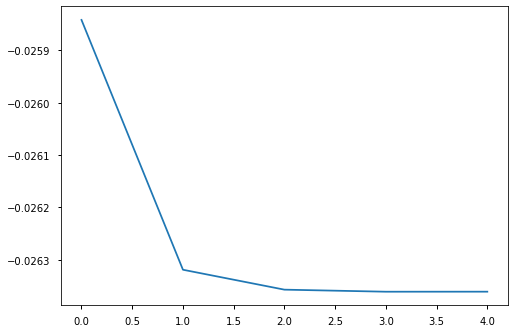

In [180]:
rob_alg, rob_nn, rob_linmod1, rob_linmod2 = rob_solve(minloss_sq, 0.95)

plt.plot(rob_alg.lvals)
plt.show()

In [181]:
print(np.array(rob_linmod1.param))
print(np.array(rob_linmod2.param))
rob_alg.K

[0.76459033 0.63424323]
[1.82639944 0.09087289]


4

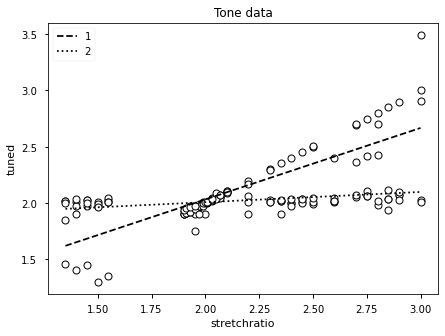

In [182]:
plt.figure(figsize=(7,5))
# plt.figure(figsize=(15,12))
plt.scatter(X, Y, s=49, c='w', edgecolors='k', linewidth=1.0)
plt.title("Tone data")
plt.plot(XX, rob_linmod1.evaluate_all(XXs), linestyle='--', label='1', color='k')
plt.plot(XX, rob_linmod2.evaluate_all(XXs), linestyle=':', label='2', color='k')
plt.xlabel('stretchratio')
plt.ylabel('tuned')
plt.legend()
# plt.savefig('fig/tonedata_scatter.eps')
plt.show()

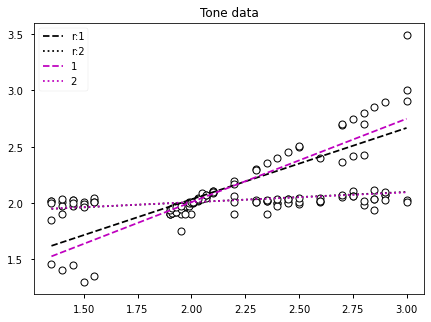

In [183]:
plt.figure(figsize=(7,5))
# plt.figure(figsize=(15,12))
plt.scatter(X, Y, s=49, c='w', edgecolors='k', linewidth=1.0)
plt.title("Tone data")
plt.plot(XX, rob_linmod1.evaluate_all(XXs), linestyle='--', label='r:1', color='k')
plt.plot(XX, rob_linmod2.evaluate_all(XXs), linestyle=':', label='r:2', color='k')
plt.plot(XX, linmod1.evaluate_all(XXs), linestyle='--', label='1', color='m')
plt.plot(XX, linmod2.evaluate_all(XXs), linestyle=':', label='2', color='m')
plt.legend()
# plt.savefig('fig/tonedata_scatter.eps')
plt.show()

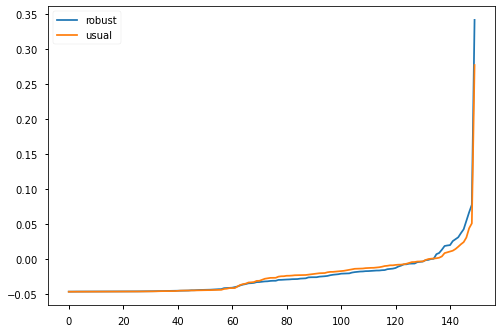

In [165]:
plt.plot(sorted(rob_alg.risk.evaluate_losses()), label='robust')
plt.plot(sorted(alg_sq.risk.evaluate_losses()), label='usual')
plt.legend()
plt.show()

In [17]:
































































































?????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????////??????????????????????????????????????????????????/?/////////////////////////////////////////////////////////////////////////////////////////////?////////////////////////////////////////////////////

Object `???????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????////??????????????????????????????????????????????????/?/////////////////////////////////////////////////////////////////////////////////////////////?///////////////////////////////////////////////////